In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torch.distributions.multivariate_normal import MultivariateNormal

from torchinfo import summary

from models import U_Net

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batchsize = 16
input_shape = (batchsize, 2, 32, 32)
num_samples_train = 8
normal_init = MultivariateNormal(torch.tensor([[0 for i in range(32*32)]]).float(), 0.15*torch.stack([torch.eye(32*32) for i in range(1)]))
train_dataset_init=(normal_init.sample([num_samples_train]).to(device).reshape(-1, 1, 32,32))

In [4]:
print(train_dataset_init.shape)

torch.Size([8, 1, 32, 32])


In [5]:
class v_model(Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape

        self.NN = U_Net(input_shape=input_shape, output_channels=1, initial_lr="", momentum="", weight_decay="")

    def forward(self, x_input, t):
        t = torch.ones_like(x_input).to(device) * t.to(device)
        inputs = torch.stack([x_input.to(device), t.to(device)], dim=2).reshape((x_input.shape[0], 2, 32,32 ))
        x = self.NN(inputs)

        return x

In [6]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)
        self.loss_curve = []

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        t = t[:,:,None, None]
        print(t.device)
        print(z0.device)
        print(z1.device)
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target


    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            t = t[:,:,None, None]
            print(t.device)
            pred = self.v_model(z, t)
            z = z.detach().clone().to(device) + pred.to(device) * dt

            trajectory.append(z.detach().clone())

        return trajectory

In [7]:
def train_rectified_flow(rectified_flow, optimizer, pairs, iterations, batchsize=128):
    loss_curve = rectified_flow.loss_curve
    for iteration in range(iterations):
        torch.cuda.empty_cache()
        
        indeces = torch.randperm(num_samples_train)
        batch = pairs[indeces][:batchsize]
        batch_init = batch[:, 0].to(device)
        batch_target = batch[:, 1].to(device)

        z_t, t, target = rectified_flow.get_train_tuple(batch_init, batch_target)
        # print("z_t: ",z_t)
        # print("t: ",t)
        # print("target: ", target[0][0])
        # print("target2: ", target[0][0][0])
        # print("target3: ", target[0][0][14])
        # plt.imshow(target[0][0].reshape(32,32).cpu().numpy())
        # plt.show()

        pred = rectified_flow.v_model(z_t, t)
        # print("pred: ", pred[0])
        # print(pred[0][0][14])
        # plt.imshow(pred[0][0].reshape(32,32).detach().cpu().numpy())
        # plt.show()
        loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        # print("loss: ", (target - pred).view(pred.shape[0], -1).abs().pow(2)[14])
        # plt.imshow((target - pred)[0,0].detach().cpu().numpy())
        # plt.show()
        loss = loss.mean()
        if iteration % 100 == 0:
            print(f"iteration: {iteration}, loss: {loss}")
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())

    rectified_flow.loss_curve = loss_curve
    return rectified_flow, loss_curve

In [8]:
device = "cpu"

In [9]:
rectified_flow_1 = torch.load("./models/MNIST_test5_2.pth")
rectified_flow_1.to(device)
rectified_flow_1.v_model.to(device)

v_model(
  (NN): U_Net(
    (NN): ModuleDict(
      (contr_1): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (contr_2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): ReLU()
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (contr_3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        

In [10]:
summary(rectified_flow_1.v_model)

Layer (type:depth-idx)                        Param #
v_model                                       --
├─U_Net: 1-1                                  --
│    └─ModuleDict: 2-1                        --
│    │    └─Sequential: 3-1                   38,400
│    │    └─Sequential: 3-2                   221,952
│    │    └─Sequential: 3-3                   886,272
│    │    └─Sequential: 3-4                   4,721,920
│    │    └─Sequential: 3-5                   2,066,048
│    │    └─Sequential: 3-6                   516,928
│    │    └─Sequential: 3-7                   111,043
│    │    └─MaxPool2d: 3-8                    --
Total params: 8,562,563
Trainable params: 8,562,563
Non-trainable params: 0

In [11]:
v_mod_2 = v_model(input_shape)
rectified_flow_2 = RectifiedFlow(v_mod_2)
flow_1 = rectified_flow_1.sample_ode(train_dataset_init.to(device), 100)
pairs_2 = torch.stack([train_dataset_init.to(device), flow_1[:][-1]], axis=1)

cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu


In [12]:
device = "cuda"
del rectified_flow_1
torch.cuda.empty_cache()
pairs_2.to(device)

tensor([[[[[-0.4546, -0.1762, -0.3908,  ..., -0.1844,  0.2989,  0.6934],
           [ 0.0217, -0.4047,  0.8609,  ...,  0.4695, -0.2404,  0.2504],
           [ 0.1815,  0.3187, -0.3597,  ..., -0.1708, -0.1321, -0.1510],
           ...,
           [ 0.2229, -0.4127,  0.3230,  ...,  0.5268,  0.4528, -0.1145],
           [-0.0775, -0.0256, -0.5750,  ..., -0.3072, -0.6188, -0.5988],
           [ 0.1163,  0.5719, -0.3990,  ...,  0.4676,  0.3722,  0.0075]]],


         [[[-1.2503, -1.0104, -1.1483,  ..., -1.0190, -0.8209, -0.4475],
           [-1.0158, -1.0972, -0.9416,  ..., -0.9629, -0.9703, -0.9250],
           [-0.9061, -0.9722, -1.0560,  ..., -1.0168, -1.0128, -1.1165],
           ...,
           [-1.0015, -1.1615, -1.0385,  ..., -0.9359, -0.9799, -1.1150],
           [-1.0097, -1.0589, -1.1087,  ..., -1.0529, -1.0793, -1.2343],
           [-1.0683, -0.9541, -1.1330,  ..., -0.9855, -0.9881, -1.1042]]]],



        [[[[-0.1859,  0.1421, -0.0315,  ..., -0.2452, -0.1949,  0.1732],
         

In [13]:
rectified_flow_2 = torch.load("./models/MNIST_test5_2__2.pth")

cuda:0
cuda:0
cuda:0
iteration: 0, loss: 202.69247436523438
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cu

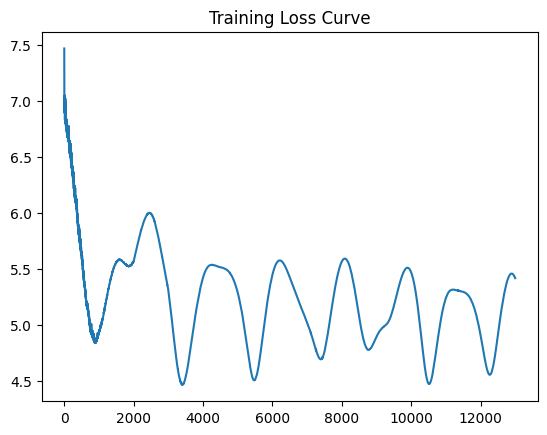

In [20]:
optimizer = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-4) #try SGD

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2.to(device), optimizer, pairs_2, iterations=10000)
torch.save(rectified_flow_2, "./models/MNIST_test5_2__2.pth")
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
tensor(-0.0322)
tensor(-0.7835)
tensor(-1.1172, device='cuda:0')


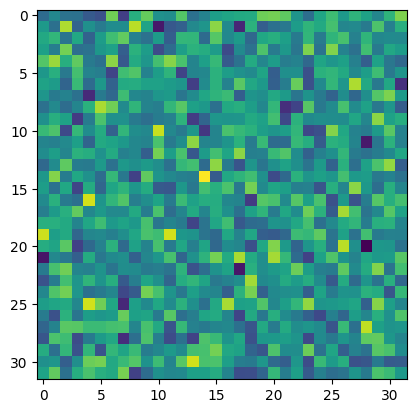

tensor([[-1.8738, -1.5953, -1.8100,  ..., -1.6036, -1.1203, -0.7258],
        [-1.3975, -1.8239, -0.5583,  ..., -0.9497, -1.6596, -1.1688],
        [-1.2377, -1.1005, -1.7788,  ..., -1.5900, -1.5512, -1.5701],
        ...,
        [-1.1963, -1.8319, -1.0961,  ..., -0.8924, -0.9664, -1.5336],
        [-1.4967, -1.4448, -1.9942,  ..., -1.7264, -2.0379, -2.0180],
        [-1.3029, -0.8472, -1.8181,  ..., -0.9516, -1.0470, -1.4117]],
       device='cuda:0')


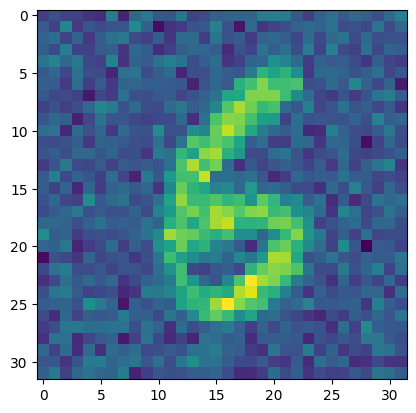

tensor([[-1.2503, -1.0104, -1.1483,  ..., -1.0190, -0.8209, -0.4475],
        [-1.0158, -1.0972, -0.9416,  ..., -0.9629, -0.9703, -0.9250],
        [-0.9061, -0.9722, -1.0560,  ..., -1.0168, -1.0128, -1.1165],
        ...,
        [-1.0015, -1.1615, -1.0385,  ..., -0.9359, -0.9799, -1.1150],
        [-1.0097, -1.0589, -1.1087,  ..., -1.0529, -1.0793, -1.2343],
        [-1.0683, -0.9541, -1.1330,  ..., -0.9855, -0.9881, -1.1042]])


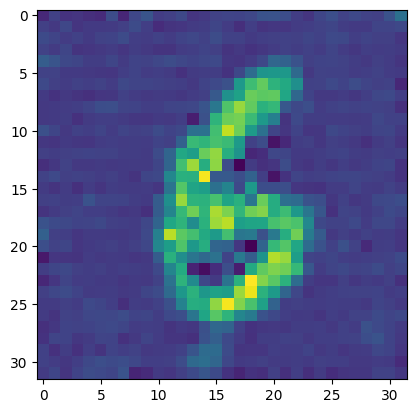

In [14]:
torch.cuda.empty_cache()
curr_img = 0
#print(batch_init.shape)
img = rectified_flow_2.sample_ode(pairs_2[:10, 0], 100)
print(torch.mean(pairs_2[curr_img, 0]))
print(torch.mean(pairs_2[curr_img, 1]))
print(torch.mean(img[-1][curr_img]))
plt.imshow(pairs_2[curr_img, 0].reshape(32,32).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(32,32).detach().cpu().numpy())
print(img[-1][curr_img].reshape(32,32))
plt.show()
plt.imshow(pairs_2[curr_img, 1].reshape(32,32).detach().cpu().numpy())
print(pairs_2[curr_img, 1].reshape(32,32))
plt.show()

In [15]:
#del train_dataset_target
torch.cuda.empty_cache()
v_mod_2 = v_model(input_shape)
rectified_flow_2 = RectifiedFlow(v_mod_2)
torch.cuda.empty_cache()
flow_1 = rectified_flow_1.sample_ode(train_dataset_init, 100)
#pairs_2 = torch.stack([train_dataset_init, flow_1[:][-1]], axis=1)

NameError: name 'rectified_flow_1' is not defined

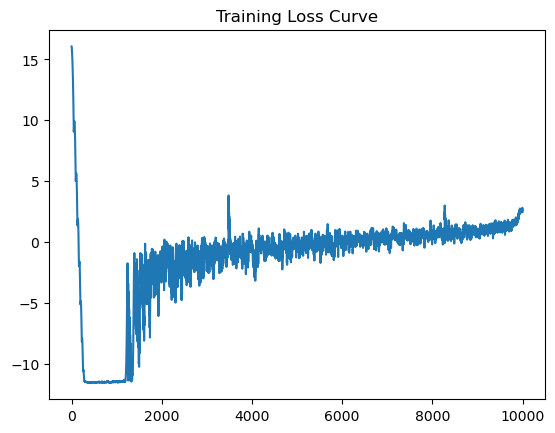

In [ ]:
optimizer = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer, pairs_2, iterations = 1000)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

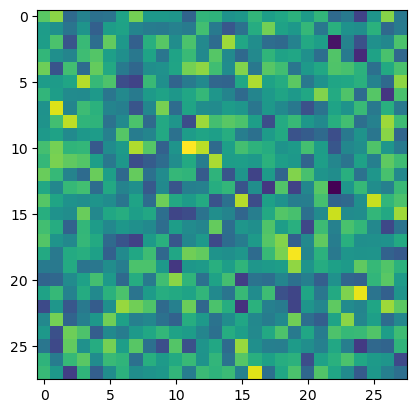

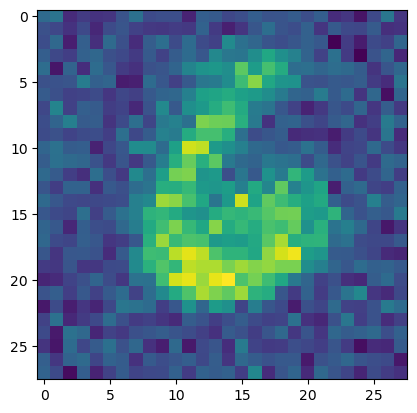

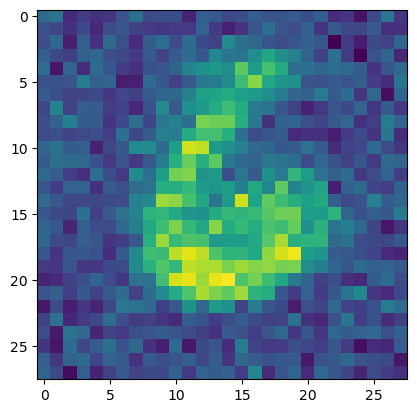

In [ ]:
curr_img = 0
img = rectified_flow_2.sample_ode(pairs_1[:100][0], 1)
plt.imshow(pairs_2[curr_img][0].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_2[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()

In [ ]:
del v_mod
torch.cuda.empty_cache()
v_mod_3 = v_model(input_dim, 784)
rectified_flow_3 = RectifiedFlow(v_mod_3)
flow_2 = rectified_flow_2.sample_ode(train_dataset_init, 100)
pairs_3 = torch.stack([train_dataset_init, flow_2[:][-1]], axis=1)

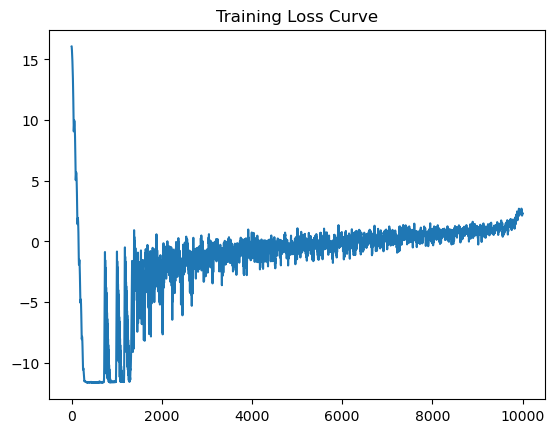

In [ ]:
optimizer = torch.optim.Adam(rectified_flow_3.v_model.parameters(), lr=5e-3)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer, pairs_3, batch_size, inner_iters)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

torch.Size([100, 784])


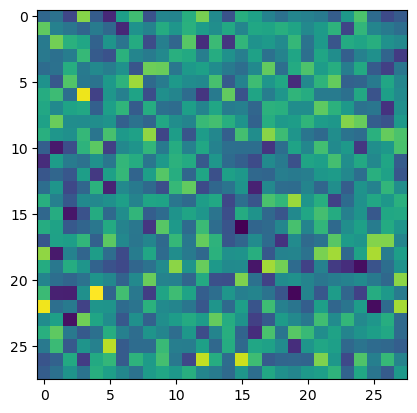

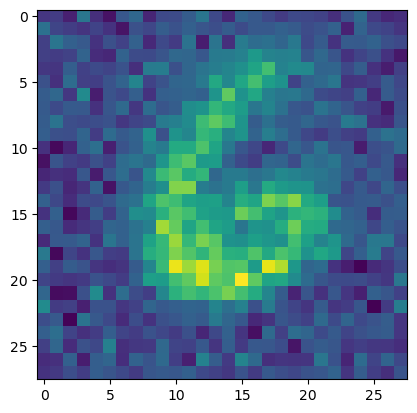

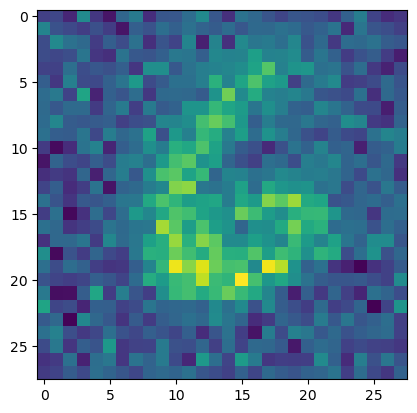

In [ ]:
curr_img = 30
img = rectified_flow_3.sample_ode(train_dataset_init[:100], 100)
print(img[-1].shape)
plt.imshow(train_dataset_init[curr_img].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_3[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[70][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()